In [13]:
# Imports
import sys
sys.path.append('../')
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import keras_cv
from keras_cv import visualization
from keras_cv import bounding_box

In [16]:
# Load the Pascal-Voc dataset

# Visualize the Keras-CV compatible dataset
def visualize_object_detection_samples(inputs, value_range, rows, cols, bounding_box_format, class_mapping):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

# Get the class mapping dictionary
def get_class_mapping(dataset_info):
    class_mapping = {i: class_info for i, class_info in enumerate(dataset_info.features['objects']['label'].names)}
    return class_mapping


# Unpackage the raw tfdf formats into Keras-CV format
def unpackage_raw_tfds_inputs(inputs, bounding_box_format):
    image = inputs["image"]
    boxes = keras_cv.bounding_box.convert_format(
        inputs["objects"]["bbox"],
        images=image,
        source="rel_yxyx",
        target=bounding_box_format,
    )
    bounding_boxes = {
        "classes": tf.cast(inputs["objects"]["label"], dtype=tf.float32),
        "boxes": tf.cast(boxes, dtype=tf.float32),
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


# Custom dataloader, compatible with Keras-CV, applies shuffling and batching
def load_pascal_voc(split, dataset, bounding_box_format):
    ds, ds_info  = tfds.load(dataset, split=split, with_info=True, shuffle_files=True)
    
    # Convert the images/bboxes to the Keras-CV API format
    ds = ds.map(
        lambda x: unpackage_raw_tfds_inputs(x, bounding_box_format=bounding_box_format),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    
    if split != 'test':
        ds = ds.shuffle(128 * 4, reshuffle_each_iteration=True)
    
    # Create ragged batches(with elems of different sizes)
    ds = ds.ragged_batch(128, drop_remainder=True)

    # Prefetch
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    return ds,ds_info


# Load the three different pre-processed splits of our dataset
ds_train, ds_info = load_pascal_voc(
    split="train", dataset="voc/2007", bounding_box_format="xywh"
)
ds_val, _ = load_pascal_voc(
    split="validation", dataset="voc/2007", bounding_box_format="xywh"
)
ds_test, _ = load_pascal_voc(
    split="test", dataset="voc/2007", bounding_box_format="xywh"
)

In [22]:
ds_info

tfds.core.DatasetInfo(
    name='voc',
    full_name='voc/2007/4.0.0',
    description="""
    This dataset contains the data from the PASCAL Visual Object Classes Challenge,
    corresponding to the Classification and Detection competitions.
    
    In the Classification competition, the goal is to predict the set of labels
    contained in the image, while in the Detection competition the goal is to
    predict the bounding box and label of each individual object.
    annotations.
    """,
    config_description="""
    This dataset contains the data from the PASCAL Visual Object Classes Challenge
    2007, a.k.a. VOC2007.
    
    A total of 9963 images are included in this dataset, where each image
    contains a set of objects, out of 20 different classes, making a total of
    24640 annotated objects.
    
    """,
    homepage='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/',
    data_dir='/home/dimitris/tensorflow_datasets/voc/2007/4.0.0',
    file_format=tfrecord,
    downlo

In [4]:
print("----Pascal-Voc dataset information-----:")
print(f"Number of training examples: {ds_info.splits['train'].num_examples}")
print(f"Number of validation examples: {ds_info.splits['validation'].num_examples}")
print(f"Number of test examples: {ds_info.splits['test'].num_examples}")
print(f"Dataset splits available: {list(ds_info.splits.keys())}")
print("Number of Classes:", len(ds_info.features["objects"]["label"].names))
print(f"Class names: {ds_info.features['objects']['label'].names}")

----Pascal-Voc dataset information-----:
Number of training examples: 2501
Number of validation examples: 2510
Number of test examples: 4952
Dataset splits available: ['test', 'train', 'validation']
Number of Classes: 20
Class names: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


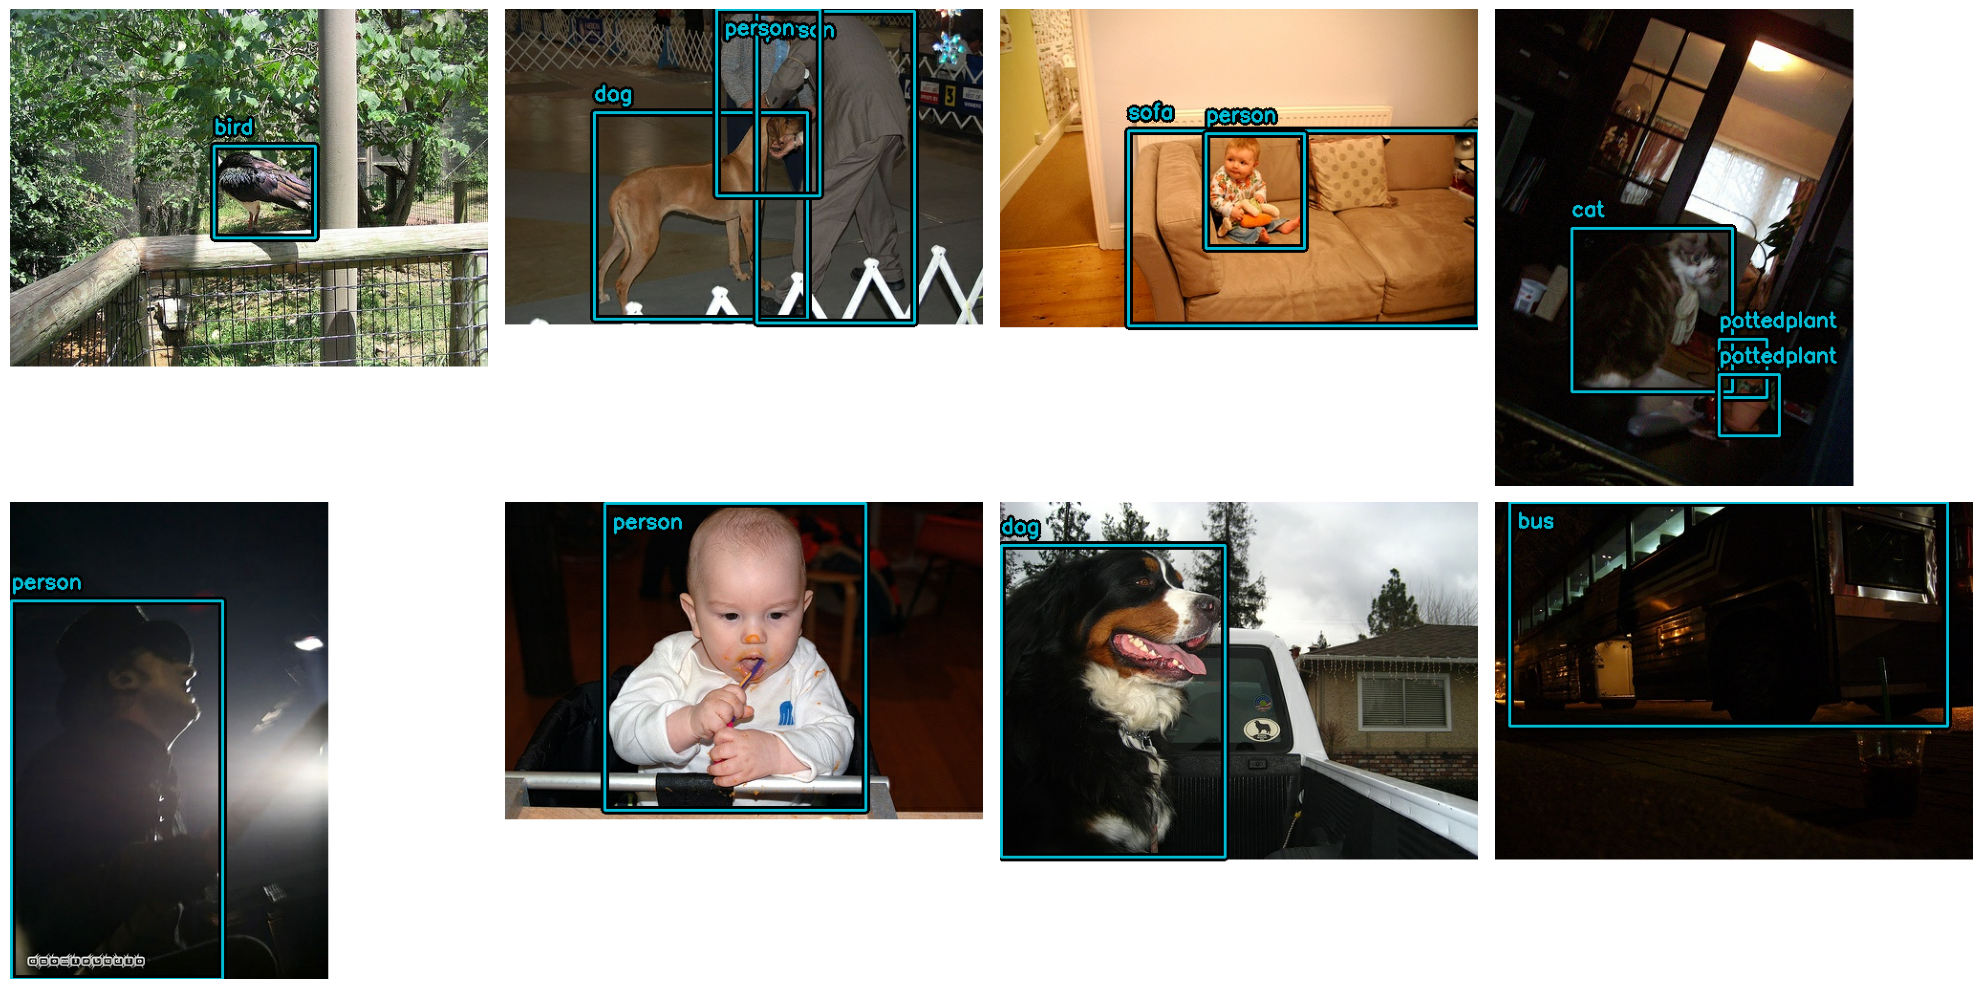

In [17]:
# Visualize some samples from the dataset
visualize_object_detection_samples(ds_train, value_range=(0, 255), rows=2, cols=4, bounding_box_format="xywh", class_mapping=get_class_mapping(ds_info))

In [ ]:
# Load a pre-trained, on the CoCo dataset, YoloV8 model
backbone =  keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_xs_backbone")
backbone.summary()

In [65]:
# Create our custom YOLO model from the smallest available backbone
model = keras_cv.models.YOLOV8Detector(
    num_classes=len(get_class_mapping(ds_info)),
    bounding_box_format="xywh",
    backbone=backbone,
    fpn_depth = 1
)
model.summary()

Model: "yolov8_detector_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 model_1 (Functional)        {'P3': (None, None, None,    1277680   ['input_6[0][0]']             
                             64),                                                                 
                              'P4': (None, None, None,                                            
                             128),                                                                
                              'P5': (None, None, None,                                            
                             256)}                                                